In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

# Anomalies detected

Patient ID 101
- Biopsy date in 2024 ???

# Utilities

In [2]:
def describe_continuous(series, param, acc=2):
    stats = series.describe()
    li = stats.tolist()
    [n, mean, std, vmin, iqr1, median, iqr2, vmax] = [round(v, acc) for v in li]
    print(f'**{param}**')
    print(f'Mean \u00B1 SD: {mean} \u00B1 {std}')
    print(f'Mean \u00B1 2SD: {mean} \u00B1 {2*std}')
    print(f'Median [IQR]: {median} [{iqr1}, {iqr2}]')
    print(f'Range: {vmin} to {vmax}')

def describe_categorical(series, label_dict, acc=1):
    vc = series.value_counts()
    indices = vc.sort_index().index.tolist()
    n = series.notna().sum()

    num = {}
    percentages = {}

    for ix in indices:
        lbl = label_dict[ix]
        num[lbl] = vc[ix]
        percentages[lbl] = round(float(vc[ix].item()) * 100 / float(n), acc)

    n_ser = pd.Series(num)
    p_ser = pd.Series(percentages)

    df = pd.DataFrame(data = {"n": n_ser, "%": p_ser})

    return df

def chi_square(series1, series2):
    ct = pd.crosstab(series1, series2)
    stat, p, dof, expected = chi2_contingency(ct)

    less_than_five = (expected < 5).sum().item()

    return {
        "stat": round(stat.item(), 4), 
        "p": round(p.item(), 4), 
        "cells_less_than_5": less_than_five
    }


# Dataset properties

In [3]:
raw_df = pd.read_csv("./working.csv")
raw_df.set_index("patient")
raw_df.head()

,patient,name,age,gender,hospital,biopsy,date,cystoscopy,who1973,second,...,cis,second11,deep,second12,last,recurrence,progressio,intravesic,bcg,radical
0,1,Amir Tamang,39,0,910385h,2247,17-01-2020,05-01-2021,2,1,...,0,0,1,1,05-01-2021,NaN,NaN,0,0,0
1,2,Indrani Mandal,62,1,950304h,39595,11-10-2018,31-12-2020,2,2,...,0,0,1,1,31-12-2020,NaN,NaN,1,0,0
2,3,Sutharan,70,0,102919h,2375,19-01-2018,12-08-2019,2,2,...,0,0,1,1,12-08-2019,NaN,NaN,1,0,0
3,4,Ali bose,48,1,112244h,2708,23-01-2018,18-02-2019,3,3,...,0,0,1,0,18-02-2019,27-02-2019,27-02-2019,0,0,1
4,5,Maheshwari,56,1,456540F,3456,29-01-2018,31-07-2018,2,1,...,0,0,0,0,31-07-2018,NaN,NaN,0,0,0


In [4]:
raw_df.columns.values

array(['patient', 'name', 'age', 'gender', 'hospital', 'biopsy', 'date',
       'cystoscopy', 'who1973', 'second', 'who2004', 'second1', 'g3',
       'second2', 'hg', 'second3', 'lamina', 'second4', 'muscularis',
       'second5', 'vascular', 'second6', 'necrosis', 'second7',
       'lymphovasc', 'second8', 'variant', 'second9', 'percentage',
       'second10', 'cis', 'second11', 'deep', 'second12', 'last',
       'recurrence', 'progressio', 'intravesic', 'bcg', 'radical'],
      dtype=object)

In [5]:
raw_df.shape

(160, 40)

In [6]:
binary_labels = {
    0: "Absent",
    1: "Present"
}

who2004_labels = {
    1: "LG",
    2: "HG"
}

who73_labels = {
    1: "G1",
    2: "G2",
    3: "G3"
}

combined_labels = {
    1: "LG/G1",
    2: "LG/G2",
    3: "HG/G2",
    4: "HG/G3"
}

pt1_labels = {
    1: "pT1a",
    2: "pT1b"
}

# Single variable descriptive statistics

## Age

In [7]:
describe_continuous(raw_df["age"], "Age", 1)

**Age**
Mean ± SD: 56.0 ± 12.5
Mean ± 2SD: 56.0 ± 25.0
Median [IQR]: 57.5 [48.0, 65.0]
Range: 22.0 to 89.0


<Axes: ylabel='Frequency'>

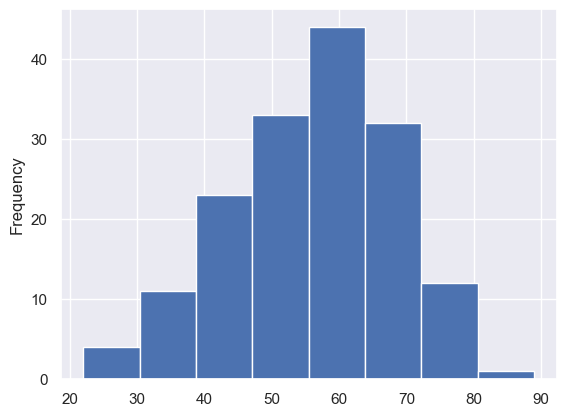

In [8]:
raw_df["age"].plot.hist(bins=8)

## Gender

In [9]:
raw_df["gender"].isna().sum()

np.int64(0)

In [10]:
raw_df["gender"] = pd.Categorical(raw_df["gender"])
raw_df["gender"].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [11]:
gender_labels = {
    0: "Male",
    1: "Female"
}
describe_categorical(raw_df["gender"], gender_labels)

,n,%
Male,137,85.6
Female,23,14.4


## Biopsy date

In [12]:
raw_df["biopsy_date"] = pd.to_datetime(raw_df["date"], dayfirst=True)

In [13]:
raw_df["biopsy_date"]

0     2020-01-17
1     2018-10-11
2     2018-01-19
3     2018-01-23
4     2018-01-29
         ...    
155   2019-04-04
156   2020-03-16
157   2017-05-30
158   2020-11-09
159   2017-12-15
Name: biopsy_date, Length: 160, dtype: datetime64[ns]

In [14]:
raw_df["biopsy_date"].describe()

count                    160
mean     2018-11-27 19:30:00
min      2017-01-04 00:00:00
25%      2017-12-30 12:00:00
50%      2018-11-18 12:00:00
75%      2019-08-15 06:00:00
max      2024-07-01 00:00:00
Name: biopsy_date, dtype: object

### ANOMALY

In [15]:
raw_df[raw_df["biopsy_date"] > "2021-01-01"]

,patient,name,age,gender,hospital,biopsy,date,cystoscopy,who1973,second,...,second11,deep,second12,last,recurrence,progressio,intravesic,bcg,radical,biopsy_date
101,102,Hriday Ranjan Das,51,0,801850g,15022,01-07-2024,10-01-2023,2,2,...,0,0,0,10-01-2023,07-01-2019,NaN,0,0,0,2024-07-01


## Cystoscopy ??

## WHO 1973 Grade

In [16]:
raw_df["who1973"] = pd.Categorical(raw_df["who1973"])
raw_df["who1973"].value_counts()

who1973
2    124
3     28
1      8
Name: count, dtype: int64

In [17]:
describe_categorical(raw_df["who1973"], who73_labels)

,n,%
G1,8,5.0
G2,124,77.5
G3,28,17.5


<Axes: xlabel='who1973', ylabel='count'>

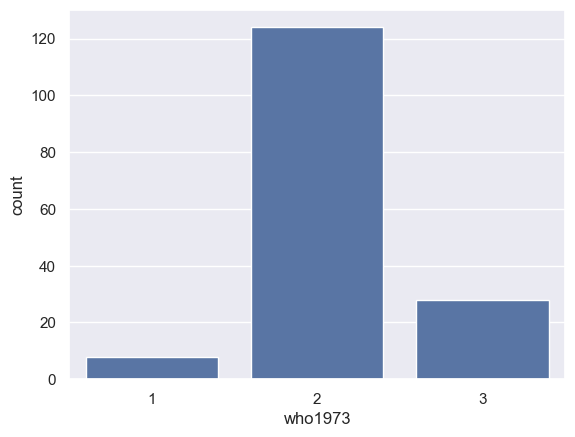

In [18]:
sns.countplot(data=raw_df, x="who1973")

## WHO 2004 Grade

In [19]:
raw_df["who2004"] = pd.Categorical(raw_df["who2004"])
raw_df["who2004"].value_counts()

who2004
1    88
2    72
Name: count, dtype: int64

In [20]:
describe_categorical(raw_df["who2004"], who2004_labels)

,n,%
LG,88,55.0
HG,72,45.0


## Combined grade

In [21]:
def combined_grade(grade73, grade04):
    # 73 :=> 1 - g1, 2 - g2, 3 - g3
    # 04 :=> 1 - lg, 2 - hg
    # combined :=> 1 - lg/g1, 2 - lg/g2, 3 - hg/g2, 4 - hg/g3
    match (grade73, grade04):
        case (1, 1):
            return 1
        case (2, 1):
            return 2
        case (2, 2):
            return 3
        case (3, 2):
            return 4
        case _:
            raise Exception("Invalid combination")
        

In [22]:
raw_df["combined"] = raw_df[["who1973", "who2004"]].apply(lambda x: combined_grade(x.who1973, x.who2004), axis=1)
raw_df["combined"] = pd.Categorical(raw_df["combined"])

In [23]:
describe_categorical(raw_df["combined"], combined_labels)

,n,%
LG/G1,8,5.0
LG/G2,80,50.0
HG/G2,44,27.5
HG/G3,28,17.5


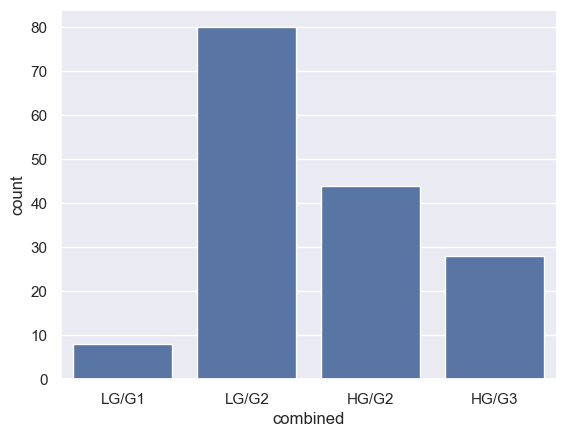

In [24]:
ax = sns.countplot(data=raw_df, x="combined")
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["LG/G1", "LG/G2", "HG/G2", "HG/G3"])
plt.show()

## Percentage G3

<Axes: ylabel='Frequency'>

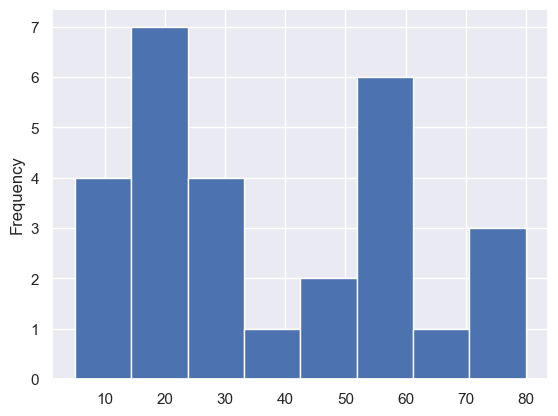

In [25]:
percentage_g3 = raw_df[raw_df["who1973"] == 3]["g3"]
percentage_g3.plot.hist(bins=8)

In [26]:
percentage_g3.describe()

count    28.000000
mean     39.285714
std      24.141339
min       5.000000
25%      20.000000
50%      30.000000
75%      60.000000
max      80.000000
Name: g3, dtype: float64

In [27]:
describe_continuous(percentage_g3, "Percentage G3")

**Percentage G3**
Mean ± SD: 39.29 ± 24.14
Mean ± 2SD: 39.29 ± 48.28
Median [IQR]: 30.0 [20.0, 60.0]
Range: 5.0 to 80.0


## Percentage HG

<Axes: ylabel='Frequency'>

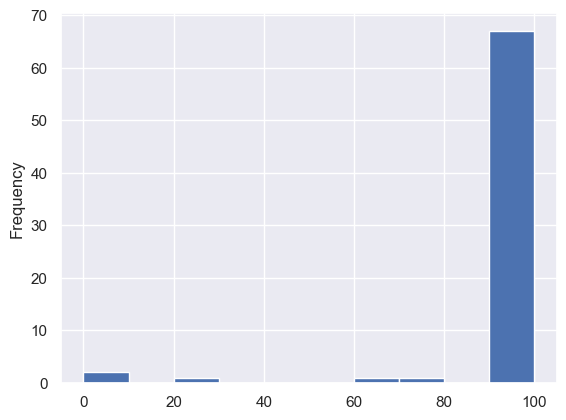

In [28]:
percentage_hg = raw_df[raw_df["who2004"] == 2]["hg"]
percentage_hg.plot.hist()

In [29]:
percentage_hg.describe()

count     72.000000
mean      95.138889
std       19.572405
min        0.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: hg, dtype: float64

In [30]:
describe_continuous(percentage_hg, "Percentage High grade")

**Percentage High grade**
Mean ± SD: 95.14 ± 19.57
Mean ± 2SD: 95.14 ± 39.14
Median [IQR]: 100.0 [100.0, 100.0]
Range: 0.0 to 100.0


## Lamina propria invasion

In [31]:
raw_df["lamina"] = pd.Categorical(raw_df["lamina"])
raw_df["lamina"].value_counts()

lamina
0    112
1     48
Name: count, dtype: int64

In [32]:
describe_categorical(raw_df["lamina"], binary_labels)

,n,%
Absent,112,70.0
Present,48,30.0


## pT1 subclass

In [33]:
raw_df["muscularis"].value_counts()

muscularis
0    152
1      8
Name: count, dtype: int64

In [34]:
pd.crosstab(raw_df["muscularis"], raw_df["lamina"])

lamina,0,1
muscularis,,
0,112,40
1,0,8


In [35]:
pd.crosstab(raw_df["vascular"], raw_df["lamina"])

lamina,0,1
vascular,,
0,112,35
1,0,13


In [36]:
raw_df.loc[raw_df["muscularis"] + raw_df["vascular"] > 0, "pt1_subclass"] = np.int64(2)

In [38]:
raw_df.loc[(raw_df["lamina"] == 1) & (raw_df["pt1_subclass"] != 2), "pt1_subclass"] = np.int64(1)

In [39]:
raw_df["pt1_subclass"] = pd.Categorical(raw_df["pt1_subclass"])

In [42]:
describe_categorical(raw_df["pt1_subclass"], pt1_labels)

,n,%
pT1a,32,66.7
pT1b,16,33.3


# More than 1 variable

## 1973 vs 2004 grade

In [ ]:
pd.crosstab(raw_df["who1973"].apply(lambda x: who73_labels[x]), raw_df["who2004"].apply(lambda x: who2004_labels[x]))

In [ ]:
chi_square(raw_df["who1973"], raw_df["who2004"])

In [ ]:
ax = sns.catplot(data=raw_df, x="who1973", kind="count", hue="who2004", legend=False)
ax.set_xticklabels(["G1", "G2", "G3"])
plt.xlabel("WHO 1973 grade")
plt.ylabel("n")
plt.legend(title="WHO 2004 grade", loc="upper right", labels=["LG", "HG"])
plt.show(ax)

## 1973 vs Lamina propria invasion

In [ ]:
pd.crosstab(raw_df["who1973"].apply(lambda x: who73_labels[x]), raw_df["lamina"].apply(lambda x: binary_labels[x]))

In [ ]:
chi_square(raw_df["who1973"], raw_df["lamina"])

In [ ]:
ax = sns.catplot(data=raw_df, x="who1973", kind="count", hue="lamina", legend=False)
ax.set_xticklabels(["G1", "G2", "G3"])
plt.xlabel("WHO 1973 grade")
plt.ylabel("n")
plt.legend(title="Lamina propria invasion", loc="upper right", labels=["Absent", "Present"])
plt.show(ax)

## 2004 vs Lamina propria invasion

In [ ]:
pd.crosstab(raw_df["who2004"].apply(lambda x: who2004_labels[x]), raw_df["lamina"].apply(lambda x: binary_labels[x]))

In [ ]:
chi_square(raw_df["who2004"], raw_df["lamina"])

In [ ]:
ax = sns.catplot(data=raw_df, x="who2004", kind="count", hue="lamina", legend=False)
ax.set_xticklabels(["LG", "HG"])
plt.xlabel("WHO 2004 grade")
plt.ylabel("n")
plt.legend(title="Lamina propria invasion", loc="upper right", labels=["Absent", "Present"])
plt.show(ax)

## Combined vs Lamina propria invasion

In [ ]:
pd.crosstab(raw_df["combined"].apply(lambda x: combined_labels[x]), raw_df["lamina"].apply(lambda x: li_labels[x]))

In [ ]:
chi_square(raw_df["combined"], raw_df["lamina"])

In [ ]:
ax = sns.catplot(data=raw_df, x="combined", kind="count", hue="lamina", legend=False)
ax.set_xticklabels(["LG/G1", "LG/G2", "HG/G2", "HG/G3"])
plt.xlabel("Combined 1973 and 2004 Grade")
plt.ylabel("n")
plt.legend(title="Lamina propria invasion", loc="upper right", labels=["Absent", "Present"])
plt.show(ax)

### Note
Can be written as a percentage of patients in each grade presenting with lamina propria invasion

## pT1 subclass vs 1973 grade

In [45]:
t1_df = raw_df[raw_df["lamina"] == 1]
pd.crosstab(t1_df["who1973"].apply(lambda x: who73_labels[x]), t1_df["pt1_subclass"].apply(lambda x: pt1_labels[x]))

pt1_subclass,pT1a,pT1b
who1973,,
G2,16,8
G3,16,8


In [47]:
chi_square(t1_df["who1973"], t1_df["pt1_subclass"])

{'stat': 0.0, 'p': 1.0, 'cells_less_than_5': 0}

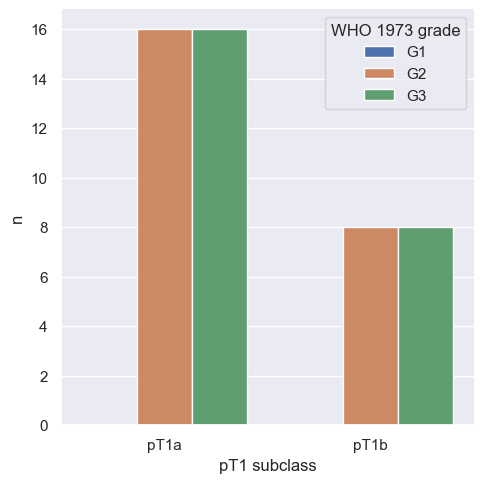

In [48]:
ax = sns.catplot(data=t1_df, x="pt1_subclass", kind="count", hue="who1973", legend=False)
ax.set_xticklabels(["pT1a", "pT1b"])
plt.xlabel("pT1 subclass")
plt.ylabel("n")
plt.legend(title="WHO 1973 grade", loc="upper right", labels=["G1", "G2", "G3"])
plt.show(ax)

## pT1 subclass vs 2004 grade

In [50]:
pd.crosstab(t1_df["who2004"].apply(lambda x: who2004_labels[x]), t1_df["pt1_subclass"].apply(lambda x: pt1_labels[x]))

pt1_subclass,pT1a,pT1b
who2004,,
LG,6,0
HG,26,16


In [51]:
chi_square(t1_df["who2004"], t1_df["pt1_subclass"])

{'stat': 1.9286, 'p': 0.1649, 'cells_less_than_5': 2}

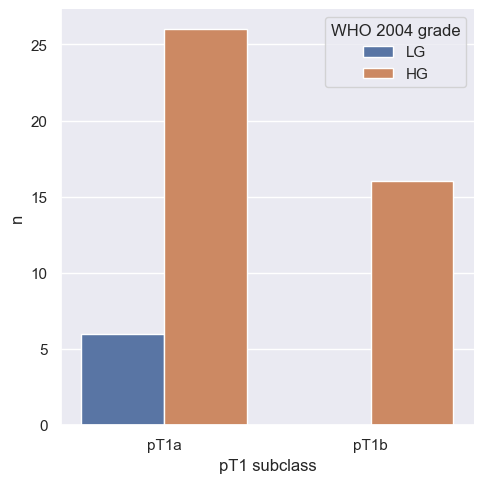

In [53]:
ax = sns.catplot(data=t1_df, x="pt1_subclass", kind="count", hue="who2004", legend=False)
ax.set_xticklabels(["pT1a", "pT1b"])
plt.xlabel("pT1 subclass")
plt.ylabel("n")
plt.legend(title="WHO 2004 grade", loc="upper right", labels=["LG", "HG"])
plt.show(ax)

## pT1 subclass vs combined grade

In [54]:
pd.crosstab(t1_df["combined"].apply(lambda x: combined_labels[x]), t1_df["pt1_subclass"].apply(lambda x: pt1_labels[x]))

pt1_subclass,pT1a,pT1b
combined,,
LG/G2,6,0
HG/G2,10,8
HG/G3,16,8


In [55]:
chi_square(t1_df["combined"], t1_df["pt1_subclass"])

{'stat': 4.0, 'p': 0.1353, 'cells_less_than_5': 2}

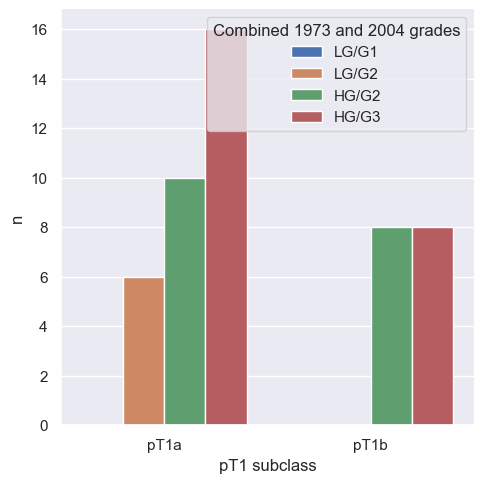

In [56]:
ax = sns.catplot(data=t1_df, x="pt1_subclass", kind="count", hue="combined", legend=False)
ax.set_xticklabels(["pT1a", "pT1b"])
plt.xlabel("pT1 subclass")
plt.ylabel("n")
plt.legend(title="Combined 1973 and 2004 grades", loc="upper right", labels=["LG/G1", "LG/G2", "HG/G2", "HG/G3"])
plt.show(ax)